## Notebook to research diabetes onset 


e) Matched Controls Diabetes Onset Curve(Blue 3)

   1. Get all the canary patients who have their CC_DIABETES flag equals 0
   on their registered date.
   
       1. Pick a matching algorithm
   2. Create the macthed population
       2. For each canary patient let their registration month be i
       2. Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       2. Set the index date for these pmpm controls patients to be month i.
       2. This forms a matched set of roughly 30 times the number of canary patients and each control has an index date.
   
   3. Compute Onset of Diabetes for month i: 
       3. Get all the matched controls with index date prior to month i.
       3. For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from e.3 that had
        the flag CC_DIABETES = 1 at Month (i) and CC_DIABETES = 0 at Month (i-1) (Note these patients must be in pmpm on both months).
       3. S is the total number of matched controls included in the pmpm both in month i and month i-1 
       3. For Month i we define the diabetes onset rate(DOR) as:
             DOR =  DO/S*1000

       3. Suggestion: Remove from  S the subjects that  have the flag CC_DIABETES = 1 at month i-1

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
#built-in
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import sys

path = str(Path.home()) + '/rpi-canary-eval/temp'
git_path = str(Path.home()) + '/rpi-canary-eval'
sys.path.append(git_path + '/modules')


#custom
import data_process
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

#options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

/home/nneehal/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load Pmpm Canary data

In [3]:
%%time
canary_p = git_path+'/data/CANARY/'
pmpm_p = git_path+'/temp/PMPM.p'

canary = pq.read_table(canary_p).to_pandas()
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 5.12 s, sys: 6.63 s, total: 11.8 s
Wall time: 11.6 s


### Log PMPM

In [4]:
%%time
pmpm.ALLOW_AMT = pmpm.ALLOW_AMT.apply(data_process.log_)

CPU times: user 13.3 s, sys: 358 ms, total: 13.6 s
Wall time: 13.6 s


### Process Canary, 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated

In [5]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 7.96 s, sys: 4.46 s, total: 12.4 s
Wall time: 12.4 s


### Keep Canary Patients from their date of registeration and onwards which did not have CC_DIABETES flag on, on their date of registration

In [6]:
%%time
treated2 = in_canary(treated.copy(), canary2)
treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 7.05 s, sys: 45.1 ms, total: 7.1 s
Wall time: 7.09 s


### Hierarchical Clustering

In [7]:
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']

treated0, treated1, model, link_matr,  clustermapdat = agglomerative(treated2.copy(), columns_to_match )

### Plot Cluster Map

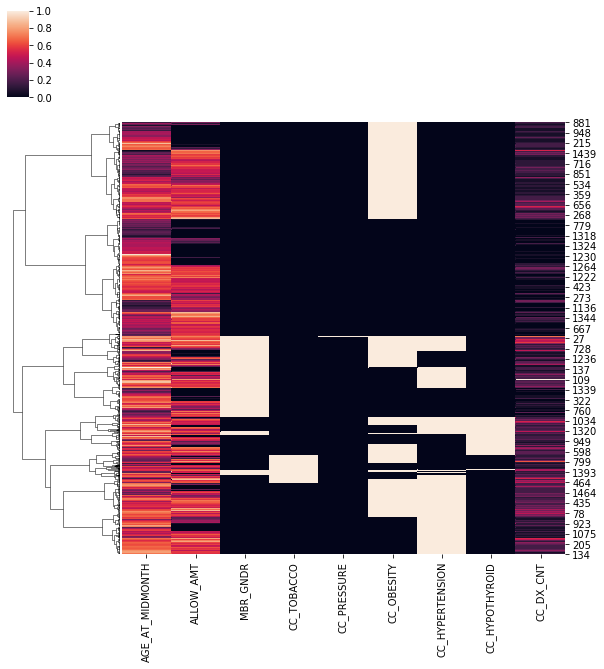

In [8]:
sns.clustermap(clustermapdat, method = 'ward', standard_scale=1, row_linkage = link_matr, col_cluster = False)

### For each patient in the treated group in its registartion month find a population of matched controls in the same month by using 

In [9]:
%%time


propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 20}
matched0, matched_data0 = matched_population(treated0.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)

matched1, matched_data1 = matched_population(treated1.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)

Mathcing Function: propensity_func


Propensity Score Matching...fitting model


/home/nneehal/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Creating Matched Set...


781it [35:56,  2.76s/it]


Mathcing Function: propensity_func


Propensity Score Matching...fitting model


/home/nneehal/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Creating Matched Set...


750it [35:11,  2.82s/it]


CPU times: user 56min 50s, sys: 29min 20s, total: 1h 26min 11s
Wall time: 1h 15min 8s


In [10]:
random_matching_func_args = {'neighbors_per_treated': 100}
random_controls = matched_population(treated2.copy(), 
                                       controls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


In [11]:
matched_data0.to_pickle(path+'/matched_orig_data/match0.p')
matched_data1.to_pickle(path+'/matched_orig_data/match1.p')
random_controls.to_pickle(path+'/matched_orig_data/random.p')
treated0.to_pickle(path+'/matched_orig_data/treated0.p')
treated1.to_pickle(path+'/matched_orig_data/treated1.p')

## Calculate the Diabetes onset for each of the created groups
1. Group 0: Group of treated patients cluster 0
2. Group 1: Group of treated patients Cluster 1
3. Group 2: Group of matched control patients to Group 0
4. Group 3: Group of matched control patients to Group 1
5. Group 4: Random Group

In [12]:
%%time
con_onset0 = diabet_onset(matched_data0.copy(), 'Diabetes_Con0')
con_onset1 = diabet_onset(matched_data1.copy(), 'Diabetes_Con1')

treated_onset0 = diabet_onset(treated0.copy(), 'Diabetes_Tr')
treated_onset1 = diabet_onset(treated1.copy(), 'Diabetes_Tr')

pmpm2 = filter_first_month_diabetes(pmpm.copy())
pmpm_onset = diabet_onset(pmpm2, 'Diabetes_PM')

CPU times: user 5min 32s, sys: 18.8 s, total: 5min 51s
Wall time: 5min 49s


In [13]:
random_onset = diabet_onset(random_controls.copy(), 'Diabetes_Rnd')

In [14]:
con_onset20 = con_onset0.rename(columns = {'Sample': 'Sample_Con0', 'Per_1000':'Per_1000_Con0'})
con_onset21 = con_onset1.rename(columns = {'Sample': 'Sample_Con1', 'Per_1000':'Per_1000_Con1'})

treated_onset20 = treated_onset0.rename(columns = {'Sample': 'Sample_Tr0', 'Per_1000':'Per_1000_Tr0'})
treated_onset21 = treated_onset1.rename(columns = {'Sample': 'Sample_Tr1', 'Per_1000':'Per_1000_Tr1'})

pmpm_onset2 = pmpm_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})

In [15]:
random_onset2 = random_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})
joint = pd.concat((con_onset20, con_onset21, treated_onset20, treated_onset21,  pmpm_onset2, random_onset2), axis = 1)

### Diabetes Onset Per Month

1. **_Con : For Matched Controls Population**
2.  **_Tr : For Canary Treated Population**
3. **_PM : For the whole PMPM Population**
4. **_Rnd: For a Random Matching**

In [16]:
joint.describe().loc[['mean', 'std']]

Sample_Con0  Diabetes_Con0  Per_1000_Con0  Sample_Con1  Diabetes_Con1  Per_1000_Con1  Sample_Tr0  Diabetes_Tr  Per_1000_Tr0  Sample_Tr1  Diabetes_Tr  Per_1000_Tr1      Sample_PM  Diabetes_PM  Per_1000_PM     Sample_PM  Diabetes_Rnd  Per_1000_PM
mean  4415.055556      10.027778       2.440624   3502.70000       5.325000       1.253910  246.638889     0.555556      1.834520  218.500000     0.400000      1.094756  142435.020408   276.795918     1.947999  30586.475000     53.225000     1.854386
std   3760.003221       8.794434       1.736297   3333.99984       5.608544       1.069552  215.405817     0.843274      4.424508  216.112506     0.708918      2.033762   13586.501014    44.652818     0.280876  27491.430218     48.010409     1.555201

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

In [18]:
joint2 = pd.concat((con_onset0, con_onset1, treated_onset0, treated_onset1,  pmpm_onset, random_onset), axis = 1)
jointcon0 = joint2.Per_1000.iloc[1:, 0].reset_index()
jointcon1 = joint2.Per_1000.iloc[1:, 1].reset_index()
jointTr0 = joint2.Per_1000.iloc[1:, 2].reset_index()

jointTr1 = joint2.Per_1000.iloc[1:, 3].reset_index()
jointpmpm = joint2.Per_1000.iloc[1:, 4].reset_index()
jointrandom = joint2.Per_1000.iloc[1:, 5].reset_index()

**Plot Top Left**: $f(x)$ = Onset Per 1000 per month </br>
**Plot Top Right and Bottom Left**: $F(x) = \int_0^x f(y)dy$ Cumulative sum of the rates

## Once and For All: _0 = sick, _1 = healthy

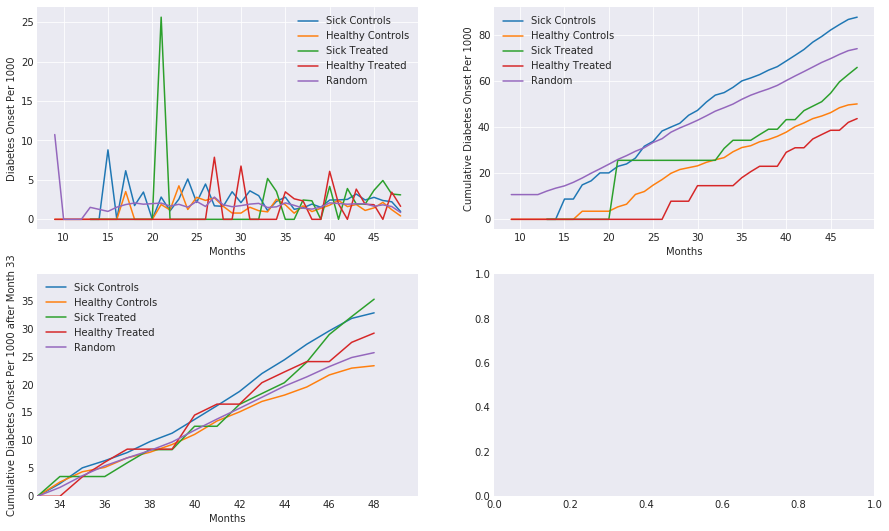

In [19]:
from diabetes_onset_plotter import plot_onset, plot_onset2
names = ['Sick Controls', 'Healthy Controls', 'Sick Treated', 'Healthy Treated', 'Random']
f, ax = plot_onset2(jointcon0, jointcon1, jointTr0, jointTr1, jointrandom, names = names)
plt.show()

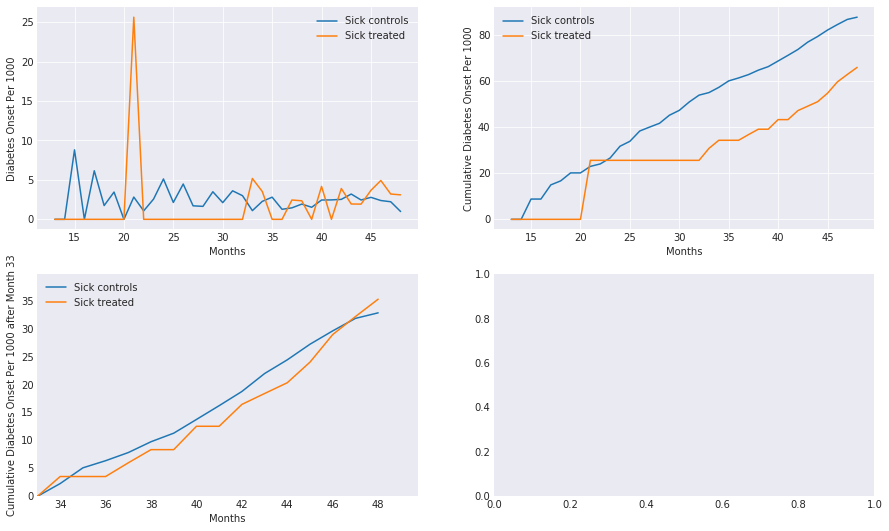

In [20]:
names = [ 'Sick controls',  'Sick treated']

f, ax = plot_onset2(jointcon0, jointTr0, names = names)


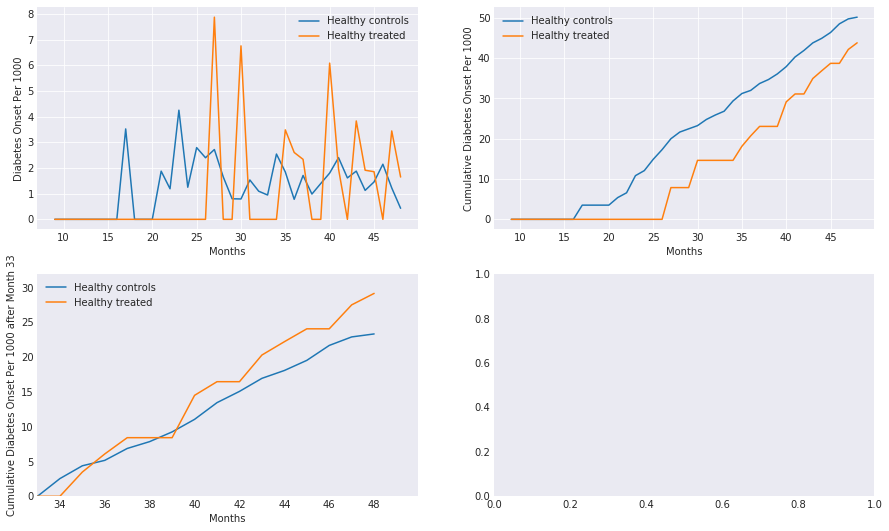

In [21]:
names = [ 'Healthy controls',  'Healthy treated']

f, ax = plot_onset2(jointcon1, jointTr1, names = names)


In [22]:
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

tr_desc0 = treated0[columns_to_match].describe().loc[['mean','std']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc0 = tr_desc0.T

tr_desc1 = treated1[columns_to_match].describe().loc[['mean','std']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc1 = tr_desc1.T

con_desc0 = matched_data0[columns_to_match].describe().loc[['mean','std']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

con_desc1 = matched_data1[columns_to_match].describe().loc[['mean','std']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc1 = con_desc1.T

pmpm_desc = pmpm2[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc = random_controls[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

alli = pd.concat((tr_desc0, tr_desc1, con_desc0, con_desc1, pmpm_desc, random_desc), axis = 1, keys = ['Sick Treated','Healthy Treated',
                                                                                                       'Sick Controls', 'Healthy Controls',
                                                                                                       'Genaral Population', 'Random'] )

In [23]:
alli

Sick Treated            Healthy Treated            Sick Controls            Healthy Controls            Genaral Population                Random           
                        mean        std            mean        std          mean        std             mean        std               mean        std       mean        std
AGE_AT_MIDMONTH    53.843361  11.711115       46.638839  12.068953     56.783497  17.261724        47.950332  14.434465          48.793934  19.418205  49.839875  19.346229
ALLOW_AMT           4.288681   2.725850        3.752427   2.860394      4.156127   2.803561         3.591078   2.887320           3.789384   2.893812   3.699700   2.901670
MBR_GNDR            0.364805   0.481400        0.000000   0.000000      0.401011   0.490105         0.000135   0.011633           0.421018   0.493722   0.418261   0.493274
CC_TOBACCO          0.118482   0.323195        0.013093   0.113680      0.134457   0.341144         0.019639   0.138757           0.099142   0.298852   0.104298   0.305647
CC_PRESSURE         0.004011   0.063209        0.000000   0.000000      0.011577   0.106973         0.002043   0.045156           0.007139   0.084192   0.007229   0.084717
CC_OBESITY          0.471254   0.499199        0.516812   0.499743      0.505240   0.499974         0.485981   0.499805           0.230098   0.420895   0.273625   0.445819
CC_HYPERTENSION     0.563818   0.495936        0.065780   0.247910      0.566697   0.495533         0.091821   0.288774           0.283202   0.450554   0.290699   0.454085
CC_HYPOTHYROID      0.160239   0.366846        0.025453   0.157505      0.154091   0.361037         0.041141   0.198617           0.069562   0.254407   0.073828   0.261492
CC_DX_CNT           3.409236   2.270185        2.135854   1.822549      3.803537   2.656330         2.169803   1.979634           2.533086   2.548243   2.693542   2.571289

### Distribution Plots For Treated and Matched Controls

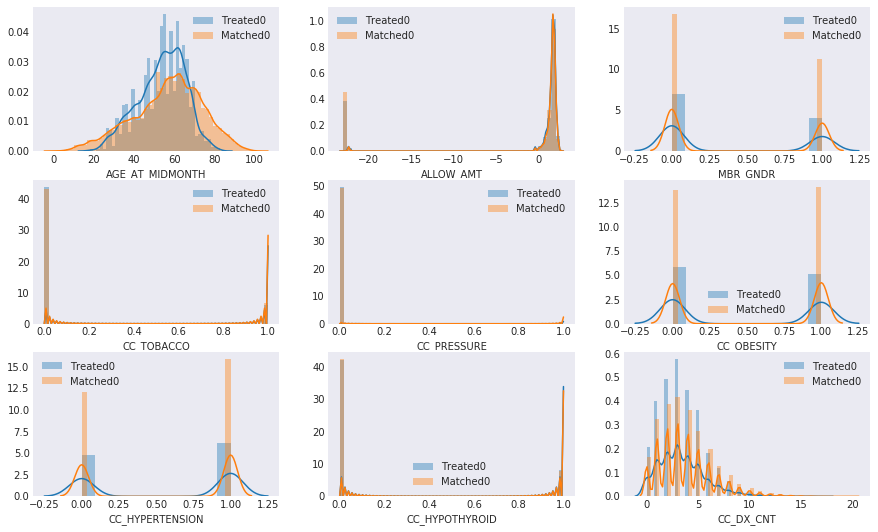

In [24]:
fig, ax = plt.subplots(3,3, figsize = (15,9))
for i in range(3):
    for j in range(3):
        column = columns_to_match[i*3 + j]
        if column == 'ALLOW_AMT':
            treated00 = treated0.copy()
            treated00[column] = np.log(treated00[column].values + 10**(-10))
            matched00 = matched_data0.copy()
            matched00[column] = np.log(matched00[column].values + 10**(-10))

            sns.distplot(treated00[column], ax = ax[i,j])
            sns.distplot(matched00[column], ax = ax[i,j])
            ax[i,j].legend(['Treated0', 'Matched0'])
        else:
            sns.distplot(treated0[column], ax = ax[i,j])
            sns.distplot(matched_data0[column], ax = ax[i, j])
            ax[i,j].legend(['Treated0', 'Matched0'])

/home/nneehal/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/nneehal/.local/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


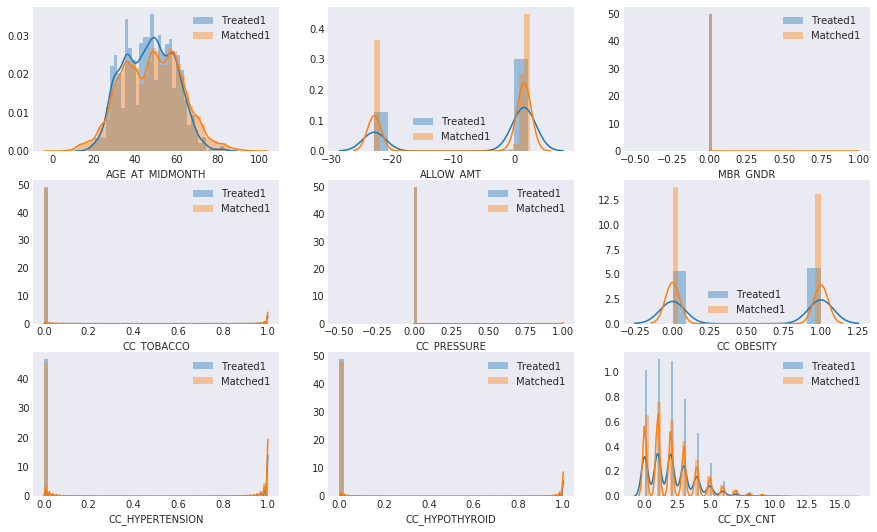

In [25]:
fig, ax = plt.subplots(3,3, figsize = (15,9))
for i in range(3):
    for j in range(3):
        column = columns_to_match[i*3 + j]
        
        try:
            if column == 'ALLOW_AMT':
                treated00 = treated1.copy()
                treated00[column] = np.log(treated00[column].values + 10**(-10))
                matched00 = matched_data1.copy()
                matched00[column] = np.log(matched00[column].values + 10**(-10))

                sns.distplot(treated00[column], ax = ax[i,j])
                sns.distplot(matched00[column], ax = ax[i,j])
                ax[i,j].legend(['Treated1', 'Matched1'])
            else:
                sns.distplot(treated1[column], ax = ax[i,j])
                sns.distplot(matched_data1[column], ax = ax[i, j])
                ax[i,j].legend(['Treated1', 'Matched1'])
        except:
            continue

In [26]:
import os
files_list = os.listdir(git_path+"/temp/matched_orig_space_data/")

In [27]:
#save in S3
import boto3
s3 = boto3.client('s3')
bucket = 'cdphp-s3-us-e-p-pond'
for file in files_list:
    s3.upload_file( git_path+"/temp/matched_orig_space_data/"+file,
                    bucket, 
                    'rpi/nneehal/DATA/matched_orig_space_data/'+file,
                    ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})